In [1]:
# import required libraries

import os
import sys
import configparser

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
from torchvision.transforms import RandomAffine
from torchvision.utils import make_grid

In [2]:
# set the device

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device)

Device is: cuda


In [3]:
# set the hyperparameters

config = configparser.ConfigParser()

config['CAE'] = {'rand_seed': 765, 'ks': 3, 'nf0': 15, 'nf1': 45, 'nf2': 128, 'nf3': 196, 'nf4': 128, 'nf5': 128, 'nf6': 128,
                 'nfc': 14}

config['IM'] = {'lambda_affine': 0.03, 'lambda_marginal_entropy': 0.1, 'lambda_conditional_entropy': 0.03,
                'learning_rate': 0.003}

config.write(sys.stdout)

[CAE]
rand_seed = 765
ks = 3
nf0 = 15
nf1 = 45
nf2 = 128
nf3 = 196
nf4 = 128
nf5 = 128
nf6 = 128
nfc = 14

[IM]
lambda_affine = 0.03
lambda_marginal_entropy = 0.1
lambda_conditional_entropy = 0.03
learning_rate = 0.003



In [4]:
rand_seed = int(config['CAE']['rand_seed'])
ks        = int(config['CAE']['ks'])
nf0       = int(config['CAE']['nf0'])
nf1       = int(config['CAE']['nf1'])
nf2       = int(config['CAE']['nf2'])
nf3       = int(config['CAE']['nf3'])
nf4       = int(config['CAE']['nf4'])
nf5       = int(config['CAE']['nf5'])
nf6       = int(config['CAE']['nf6'])
nfc       = int(config['CAE']['nfc'])

In [5]:
lambda_affine              = float(config['IM']['lambda_affine'])
lambda_marginal_entropy    = float(config['IM']['lambda_marginal_entropy'])
lambda_conditional_entropy = float(config['IM']['lambda_conditional_entropy'])
learning_rate              = float(config['IM']['learning_rate'])

In [6]:
# set random seed

print('random seed:', rand_seed)

torch.manual_seed(rand_seed)
torch.cuda.manual_seed(rand_seed)
np.random.seed(rand_seed)

random seed: 765


In [7]:
# load the dataset

data_src = np.load('/project/dsc-is/mahfujul-r/M/slice64_Block2_20K.npy')

In [8]:
# custom functions to extract batches of samples

def get_batch_index_tr(tr, batch_size=None, shuffle=True):
    if (shuffle):
        np.random.shuffle(tr)
    if (batch_size is not None):
        n_batch = len(tr) // batch_size
    batch_list = np.array_split(tr, n_batch)
    return batch_list

def get_batch_index_ae(ae, batch_size=None, shuffle=True):
    tr = np.arange(ae)
    batch_list = get_batch_index_tr(tr, batch_size=batch_size, shuffle=shuffle)
    return batch_list

In [9]:
ix, iy = 64, 64 # 64x64 patches are not getting rescaled like 128x128 patches

#affine transformation
add_random_affine = RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), fill=(161, 138, 172)) 

def generate_batch(iii, src, device, random_affine=False):
    if (random_affine):
        tmp = np.empty((len(iii), ix, iy, nf0))
        for aa, ii in enumerate(iii):
            img_tmp0 = Image.fromarray(src[ii, 0])
            img_tmp0 = add_random_affine(img_tmp0) # HE
            img_tmp4 = Image.fromarray(src[ii, 4])
            img_tmp4 = add_random_affine(img_tmp4) # CD31
            img_tmp5 = Image.fromarray(src[ii, 5])
            img_tmp5 = add_random_affine(img_tmp5) # CK19
            img_tmp6 = Image.fromarray(src[ii, 6])
            img_tmp6 = add_random_affine(img_tmp6) # Ki67
            img_tmp7 = Image.fromarray(src[ii, 7])
            img_tmp7 = add_random_affine(img_tmp7) # MT
            tmp[aa] = np.concatenate((img_tmp0, img_tmp4, img_tmp5, img_tmp6, img_tmp7), axis=2)
        xxx = torch.tensor(tmp/255.0, dtype=torch.float32).permute(0, 3, 2, 1)
    
    else:
        tmp = np.empty((len(iii), ix, iy, nf0))
        for aa, ii in enumerate(iii):
            img_tmp0 = Image.fromarray(src[ii, 0]) # HE
            img_tmp4 = Image.fromarray(src[ii, 4]) # CD31
            img_tmp5 = Image.fromarray(src[ii, 5]) # CK19
            img_tmp6 = Image.fromarray(src[ii, 6]) # Ki67
            img_tmp7 = Image.fromarray(src[ii, 7]) # MT
            tmp[aa] = np.concatenate((img_tmp0, img_tmp4, img_tmp5, img_tmp6, img_tmp7), axis=2)
        xxx = torch.tensor(tmp/255.0, dtype=torch.float32).permute(0, 3, 2, 1)
    
    return (xxx.to(device))

`CAE` (Convolutional AutoEncoder) architecture

- `Encoder` class

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential()
        self.encoder.add_module('conv1', nn.Conv2d(in_channels=nf0, out_channels=nf1, kernel_size=4, stride=2, padding=1))
        self.encoder.add_module('bnor1', nn.BatchNorm2d(num_features=nf1, affine=True, track_running_stats=True))
        self.encoder.add_module('lrel1', nn.LeakyReLU(0.1, inplace=True))
        self.encoder.add_module('conv2', nn.Conv2d(in_channels=nf1, out_channels=nf2, kernel_size=4, stride=2, padding=1))
        self.encoder.add_module('bnor2', nn.BatchNorm2d(num_features=nf2, affine=True, track_running_stats=True))
        self.encoder.add_module('lrel2', nn.LeakyReLU(0.1, inplace=True))
        self.encoder.add_module('conv3', nn.Conv2d(in_channels=nf2, out_channels=nf3, kernel_size=4, stride=2, padding=1))
        self.encoder.add_module('bnor3', nn.BatchNorm2d(num_features=nf3, affine=True, track_running_stats=True))
        self.encoder.add_module('lrel3', nn.LeakyReLU(0.1, inplace=True))
        self.encoder.add_module('conv4', nn.Conv2d(in_channels=nf3, out_channels=nf4, kernel_size=4, stride=2, padding=1))
        self.encoder.add_module('bnor4', nn.BatchNorm2d(num_features=nf4, affine=True, track_running_stats=True))
        self.encoder.add_module('lrel4', nn.LeakyReLU(0.1, inplace=True))
        
    def forward(self, xxx):
        hhh = self.encoder(xxx)        
        return hhh

- `Classifier` class

In [11]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.classifier = nn.Sequential()
        self.classifier.add_module('conv1', nn.Conv2d(in_channels=nf4, out_channels=nf5, kernel_size=4, stride=1, padding=0))
        self.classifier.add_module('bnor1', nn.BatchNorm2d(num_features=nf5, affine=True, track_running_stats=True))
        self.classifier.add_module('lrel1', nn.LeakyReLU(0.1, inplace=True))
        self.classifier.add_module('conv2', nn.Conv2d(in_channels=nf5, out_channels=nf6, kernel_size=1, stride=1, padding=0))
        self.classifier.add_module('lrel2', nn.LeakyReLU(0.1, inplace=True))
        self.classifier.add_module('conv3', nn.Conv2d(in_channels=nf6, out_channels=nfc, kernel_size=1, stride=1, padding=0))
        self.classifier.add_module('lrel3', nn.LeakyReLU(0.1, inplace=True))
        
    def forward(self, hhh):
        vvv = self.classifier(hhh)
        return vvv

- `Decoder` class

In [12]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential()
        self.decoder.add_module('upsm4', nn.UpsamplingBilinear2d(scale_factor=2))
        self.decoder.add_module('dcov4', nn.Conv2d(in_channels=nf4 + nfc, out_channels=nf3, kernel_size=3, stride=1, padding=1))
        self.decoder.add_module('norm4', nn.BatchNorm2d(num_features=nf3, affine=True, track_running_stats=True))
        self.decoder.add_module('lrel4', nn.LeakyReLU(0.1, inplace=True))
        self.decoder.add_module('upsm3', nn.UpsamplingBilinear2d(scale_factor=2))
        self.decoder.add_module('dcov3', nn.Conv2d(in_channels=nf3, out_channels=nf2, kernel_size=3, stride=1, padding=1))
        self.decoder.add_module('norm3', nn.BatchNorm2d(num_features=nf2, affine=True, track_running_stats=True))
        self.decoder.add_module('lrel3', nn.LeakyReLU(0.1, inplace=True))
        self.decoder.add_module('upsm2', nn.UpsamplingBilinear2d(scale_factor=2))
        self.decoder.add_module('dcov2', nn.Conv2d(in_channels=nf2, out_channels=nf1, kernel_size=3, stride=1, padding=1))
        self.decoder.add_module('norm2', nn.BatchNorm2d(num_features=nf1, affine=True, track_running_stats=True))
        self.decoder.add_module('lrel2', nn.LeakyReLU(0.1, inplace=True))
        self.decoder.add_module('upsm1', nn.UpsamplingBilinear2d(scale_factor=2))
        self.decoder.add_module('dcov1', nn.Conv2d(in_channels=nf1, out_channels=nf0, kernel_size=3, stride=1, padding=1))
        self.decoder.add_module('norm1', nn.BatchNorm2d(num_features=nf0, affine=True, track_running_stats=True))
        self.decoder.add_module('sgmd1', nn.Sigmoid())
        
    def forward(self, hhh, vvv):
        ccc = vvv.repeat((1, 1, ix//16, iy//16))
        hhh = torch.cat((hhh, ccc), dim=1)
        yyy = self.decoder(hhh)
        return yyy

In [13]:
model_en = Encoder().to(device)
model_cl = Classifier().to(device)
model_de = Decoder().to(device)

# load models
model_en.load_state_dict(torch.load('models14/model_encoder_3000'))
model_cl.load_state_dict(torch.load('models14/model_classifier_3000'))
model_de.load_state_dict(torch.load('models14/model_decoder_3000'))

<All keys matched successfully>

In [14]:
iii_batch = get_batch_index_ae(15000, batch_size=100, shuffle=False) # first 15000 samples

hhh_list = []

with torch.inference_mode():
    for iii in iii_batch:
        xxx_tmp = generate_batch(iii, data_src, device)
        
        model_en.eval()
        
        hhh_tmp = model_en(xxx_tmp)
        
        hhh_list.append(torch.softmax(hhh_tmp, dim=1).detach().cpu().numpy())
        
    hhh = np.concatenate(hhh_list, axis=0)
    print('Shape of upper latent space:', hhh.shape)

Shape of upper latent space: (15000, 128, 4, 4)


In [15]:
a = np.mean(hhh, axis=3)
a = np.mean(a, axis=2)
a.shape # embedded features in upper latent space

(15000, 128)

In [16]:
iii_batch = get_batch_index_ae(15000, batch_size=100, shuffle=False) # first 15000 samples

vvv_list = []

with torch.inference_mode():
    for iii in iii_batch:
        xxx_tmp = generate_batch(iii, data_src, device)
        
        model_en.eval()
        model_cl.eval()
        
        hhh_tmp = model_en(xxx_tmp)
        vvv_tmp = model_cl(hhh_tmp)
        
        vvv_list.append(torch.softmax(vvv_tmp.reshape((-1, nfc)), dim=1).detach().cpu().numpy())
        
    vvv_15k = np.concatenate(vvv_list, axis=0)
    print('Embedded features in lower latent space:', vvv_15k.shape)

Embedded features in lower latent space: (15000, 14)


In [17]:
C = []
D = []

for j in range(len(vvv_15k)):
    hemp1 = vvv_15k[j, :]
    hemp2 = np.argmax(hemp1)
    hemp3 = hemp1[hemp2]
    C.append(hemp2) # collect cluster IDs with highest probability for each patch
    D.append(hemp3) # collect highest probability of each patch

In [18]:
DF = pd.DataFrame(a)
DF['128'] = C
DF['129'] = D
DF # this dataframe contains embedded features from upper latent space, cluster IDs and highest probability (of each patch) 

0         1         2         3         4         5         6  \
0      0.011962  0.001973  0.001367  0.002962  0.001333  0.002202  0.005769   
1      0.008064  0.010953  0.009322  0.011646  0.006200  0.005369  0.006142   
2      0.005828  0.006005  0.008902  0.009051  0.004843  0.004849  0.007855   
3      0.006149  0.005634  0.008347  0.008073  0.004685  0.004833  0.009480   
4      0.005791  0.005341  0.009822  0.006371  0.004835  0.005234  0.010832   
...         ...       ...       ...       ...       ...       ...       ...   
14995  0.007620  0.007319  0.009012  0.012710  0.006625  0.005289  0.005173   
14996  0.012554  0.022392  0.003200  0.010719  0.017043  0.014301  0.003222   
14997  0.008051  0.010103  0.005452  0.006872  0.012319  0.004491  0.004124   
14998  0.006876  0.005998  0.008397  0.007003  0.005234  0.005256  0.010247   
14999  0.011249  0.017772  0.003552  0.010052  0.015996  0.008911  0.003489   

              7         8         9  ...       120       121       122  \
0      0.033465  0.004345  0.001430  ...  0.017195  0.174118  0.005366   
1      0.005812  0.005321  0.009789  ...  0.008011  0.005950  0.007898   
2      0.004944  0.005632  0.013177  ...  0.005849  0.004885  0.008707   
3      0.005227  0.005994  0.010910  ...  0.004797  0.004581  0.008218   
4      0.005005  0.005643  0.010369  ...  0.005768  0.004834  0.008741   
...         ...       ...       ...  ...       ...       ...       ...   
14995  0.005985  0.006173  0.009403  ...  0.012556  0.008432  0.006117   
14996  0.006407  0.005324  0.006136  ...  0.004529  0.003864  0.005903   
14997  0.004909  0.003900  0.005739  ...  0.006884  0.004769  0.004693   
14998  0.005515  0.005823  0.010079  ...  0.006449  0.005270  0.007149   
14999  0.005747  0.004129  0.005910  ...  0.005393  0.004087  0.004922   

            123       124       125       126       127  128       129  
0      0.001239  0.001277  0.002776  0.001352  0.001185    5  0.999202  
1      0.007503  0.007313  0.006418  0.007806  0.012057    4  0.954563  
2      0.005392  0.006232  0.004846  0.005679  0.010585    9  0.991519  
3      0.004854  0.005360  0.004903  0.005528  0.009502    9  0.993510  
4      0.005154  0.009980  0.005285  0.007962  0.007531    9  0.793973  
...         ...       ...       ...       ...       ...  ...       ...  
14995  0.010189  0.005029  0.006159  0.005143  0.011580   12  0.938352  
14996  0.010401  0.007785  0.003810  0.008888  0.005620   13  0.995013  
14997  0.008354  0.011107  0.004369  0.015668  0.004940    8  0.999779  
14998  0.005652  0.007774  0.006983  0.007518  0.007937    9  0.980402  
14999  0.009599  0.008284  0.003975  0.012533  0.005009   13  0.999637  

[15000 rows x 130 columns]

In [ ]:
# 'HHH14 & C14 & D14.csv' file will be saved in this location ---> '/project/dsc-is/mahfujul-r/M/64/14'

DF.to_csv('/project/dsc-is/mahfujul-r/M/64/14/HHH14 & C14 & D14.csv', index=None, header=None) # save DF as a '.csv' file

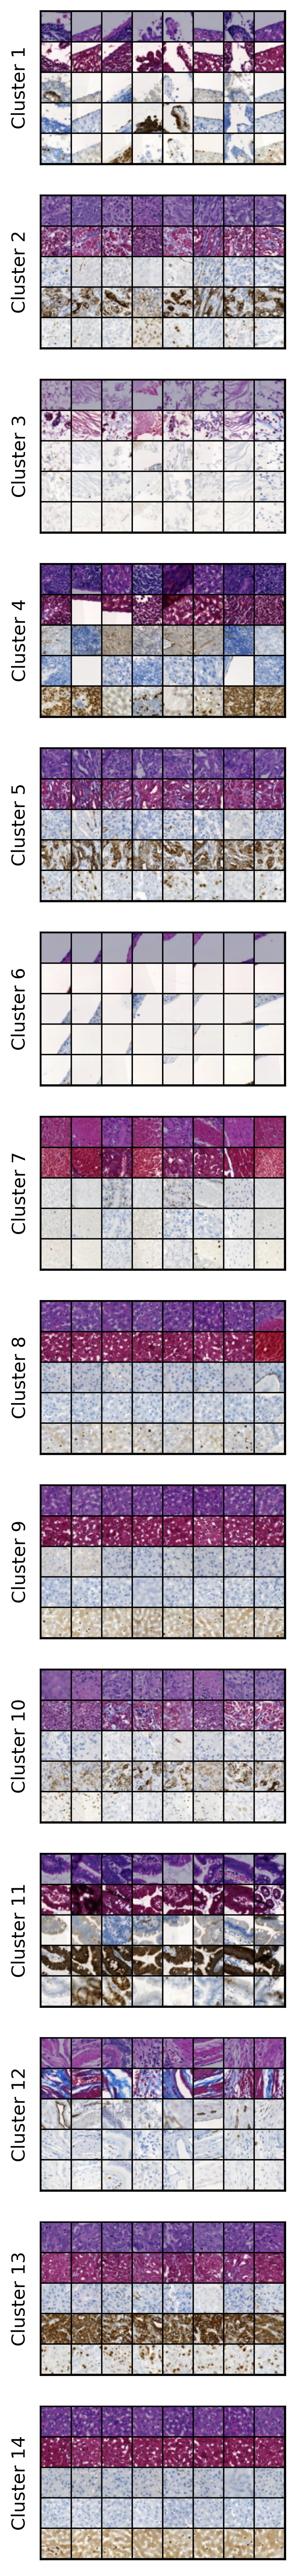

In [19]:
# clustering

fig, plts = plt.subplots(nrows=14, ncols=1)

for cc in range(nfc):
    iii = np.argsort(-vvv_15k[:, cc])
    
    tmp_p1 = []
    tmp_p2 = []
    tmp_p3 = []
    tmp_p4 = []
    tmp_p5 = []
    
    for aa in range(8):
        tmp_p1.append(torch.from_numpy(data_src[iii[aa], 0]).permute(2, 0, 1))
        tmp_p2.append(torch.from_numpy(data_src[iii[aa], 7]).permute(2, 0, 1))
        tmp_p3.append(torch.from_numpy(data_src[iii[aa], 4]).permute(2, 0, 1))
        tmp_p4.append(torch.from_numpy(data_src[iii[aa], 5]).permute(2, 0, 1))
        tmp_p5.append(torch.from_numpy(data_src[iii[aa], 6]).permute(2, 0, 1))
    
    grid = make_grid([tmp_p1[0], tmp_p1[1], tmp_p1[2], tmp_p1[3], tmp_p1[4], tmp_p1[5], tmp_p1[6], tmp_p1[7],
                      tmp_p2[0], tmp_p2[1], tmp_p2[2], tmp_p2[3], tmp_p2[4], tmp_p2[5], tmp_p2[6], tmp_p2[7],
                      tmp_p3[0], tmp_p3[1], tmp_p3[2], tmp_p3[3], tmp_p3[4], tmp_p3[5], tmp_p3[6], tmp_p3[7],
                      tmp_p4[0], tmp_p4[1], tmp_p4[2], tmp_p4[3], tmp_p4[4], tmp_p4[5], tmp_p4[6], tmp_p4[7],
                      tmp_p5[0], tmp_p5[1], tmp_p5[2], tmp_p5[3], tmp_p5[4], tmp_p5[5], tmp_p5[6], tmp_p5[7]],
                      nrow=8, padding=3)
    
    img = torchvision.transforms.ToPILImage()(grid)
    plts[cc].imshow(img)
    plts[cc].set_ylabel('Cluster {}'.format(cc + 1), fontsize=12)
    plts[cc].set_xticks([])
    plts[cc].set_yticks([])

fig.set_size_inches((10, 30))
fig.set_dpi(300)
fig.show()